# Résolution de systèmes linéaires

En simulation numérique pour la mécanique, on ramène le problème initial (équilibre + loi de comportement) en un problème d'algèbre pour lequel des méthodes puissantes de résolution peuvent être appliquées. 

Dans le cas où le comportement est linéaire, le problème peut se ramène usuellement à la formulation suivante :
$$
\mathbf K \cdot \mathbf U = \mathbf F_{ext}
$$
    où $\mathbf K \in \mathbb R^{n_{dof}\times n_{dof}}$ est la matrice de rigidité, $\mathbf U \in \mathbb R^{n_{dof}}$ le vecteur inconnu des degrés de libertés et $\mathbf F_{ext}\in \mathbb R^{n_{dof}}$ le vecteur des efforts externes. On fait alors apparaïtre un problème classique d'algèbre linéaire de la forme :
$$
\mathbf A \cdot \mathbf x = \mathbf b
$$
Nous garderons ces notations par la suite.

On rencontre alors deux grandes familles de méthodes de résolution :
- les methodes **directes**, qui permettent d'obtenir la solution exacte du problème,
- les méthodes **itératives**, pour lesquelles la solution est approchée de plus en plus précisément à chaque répétition d'une séquence de calcul.

## Méthodes directes

On commence par détailler les méthodes directes, qui se basent sur des méthodes d'algèbre linéaire. C'est souvent un choix pertinent en première approche. Les **solveurs** directs ont le côté "rassurant" de ne pas avoir de problème de convergence, contrairement au solveurs itératifs.

Bien qu'on puisse noter que :
$$
\mathbf x = 
\mathbf A^{-1}\cdot 
\mathbf b,
$$
on ne calcule en pratique jamais $\mathbf A^{-1}$. Si jamais il vous vient l'idée saugrenue de faire : 

In [8]:
import numpy as np
import numpy.linalg as la

A = np.random.random((3, 3))
b = np.random.random((3, 1))

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Ne faites PAS ça!!!!
A_inv = la.inv(A)
x = A_inv.dot(b) 
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

... changez d'idée! L'inversion de la matrice est une étape très coûteuse, en $O(n^3)$ et vous enchaîneé par un produit matrice-vecteur en $O(n^2)$. Cette méthode est catastrophique en termes de performances.  
On préfèrera par exemple se ramener à une matrice **triangulaire** pour laquelle la résolution du système est particulèrement rapide comme nous allons le voir maintenant.

### Résolution d'un système triangulaire *

On considère le cas où $\mathbf A$ est triangulaire supérieure. Pour $n_{dof} = 4$, on travaille avec un problème de la forme : 
$$
\begin{pmatrix}
A_{11} & A_{12} & A_{13} & A_{14} \\
0 & A_{22} & A_{23} & A_{24}\\
0 & 0 & A_{33} & A_{34} \\
0 & 0 & 0 & A_{44}
\end{pmatrix}
\cdot 
\begin{pmatrix}
x_1\\
x_2 \\
x_3 \\
x_4
\end{pmatrix}
= 
\begin{pmatrix}
b_1\\
b_2 \\
b_3 \\
b_4
\end{pmatrix}.
$$
En partant de la dernière composante (ici $x_4$), on a :
$$
x_4 =  \frac{b_4}{A_{44}},
$$
puis en remontant :
$$
x_3 = 
\frac{1}{A_{33}}
(b_4 - A_{34}x_4),
$$
et ainsi de suite. On généralise alors l'expression :
$$
x_i = \frac{1}{A_{ii}}\left (b_i - \sum_{j > i} A_{ij} x_j \right).
$$
On comprend donc que la résolution du système à partir d'une matrice triangulaire est particulièrement aisée, avec une complexité en $O(n^2)$. Par la suite, on cherchera à ramener le problème algèbrique initial à un problème de ce type.

In [3]:
import numpy as np 

A = np.array([[1., 2., 3., 4.], [0., 5., 6., 7.], [0., 0., 8., 9.], [0., 0., 0., 10.]])
b = np.array([1., 2., 3., 4.])

print("A : \n", A)
print("b : \n", b)

N = b.size
x = np.zeros_like(b)

for i in reversed(range(N)):
    s = 0
    for j in range(i + 1, N):
        s += A[i, j]*x[j]
    
    x[i] = (b[i] - s)/A[i, i]

print("A.dot(x) : ", A.dot(x))

A : 
 [[ 1.  2.  3.  4.]
 [ 0.  5.  6.  7.]
 [ 0.  0.  8.  9.]
 [ 0.  0.  0. 10.]]
b : 
 [1. 2. 3. 4.]
A.dot(x) :  [1. 2. 3. 4.]


### Élimination de Gauss-Jordan (ou pivot de Gauss) *

La méthode du **pivot de Gauss** est une méthode très courante pour se ramener à un problème matriciel triangulaire. En considérant un problème initial de la forme : 
$$
\mathbf A \cdot \mathbf x = \mathbf b,
$$
on aboutit à problème équivalent de la forme : 
$$
\tilde{\mathbf A} \cdot \mathbf x = \tilde{\mathbf b},
$$
où $\tilde{\mathbf A} \in \mathbb R^{n_{dof}\times n_{dof}}$ est une matrice triangulaire supérieure. On considérera $\mathbf{Ab}$ la concaténation de $\mathbf A$ et $\mathbf b$ : 
$$
\mathbf{Ab} = 
\begin{pmatrix}
A_{11} & \cdots & A_{1n_{dof}} & b_1 \\
0 & \ddots & \vdots & \vdots\\
0 & 0 & A_{n_{dof} n_{dof}} & b_{4} 
\end{pmatrix}
\in \mathbb R^{n_{dof}\times n_{dof}+1}
$$
avec $L_i$, la ligne $i$ de $\mathbf{Ab}$.

On observe que la solution du système reste la même lorsqu'on applique à $\mathbf{Ab}$ certaines opérations : 
- **Permutation de lignes** : on intervertit les lignes $L_i$ et $L_j$
- **Combinaison linéaire** sur une ligne : $L_i$ devient $\alpha_i L_i + \alpha_j L_j + \alpha_k L_k + \cdots$

En jouant sur ce principe, on peut s'arranger pour éliminer la partie triangulaire inférieure de $\mathbf A$ et aboutir au système équivalent souhaité.

On donne un exemple pour $n_{dof} = 3$, on part de :
$$
\mathbf{Ab}^{(0)} = 
\begin{pmatrix}
A_{11} & A_{12} & A_{13} & b_1 \\
A_{21} & A_{22} & A_{23} & b_2\\
A_{31} & A_{32} & A_{33} & b_3 
\end{pmatrix}
\begin{matrix}
L_1 \\
L_2 \\
L_3
\end{matrix}
$$
puis par combinaison linéaire : 
$$
\mathbf{Ab}^{(1)} = 
\begin{pmatrix}
A_{11} & A_{12} & A_{13} & b_1 \\
0 & A_{22}' & A_{23}' & b_2'\\
0 & A_{32}' & A_{33}' & b_3 '
\end{pmatrix}
\begin{matrix}
L_1 \\
L_2 \leftarrow L_2 - \frac{A_{21}}{A_{11}} L_1 \\
L_3 \leftarrow L_3 - \frac{A_{31}}{A_{11}} L_1
\end{matrix}
$$
enfin :
$$
\mathbf{Ab}^{(2)} = 
\begin{pmatrix}
A_{11} & A_{12} & A_{13} & b_1 \\
0 & A_{22}' & A_{23}' & b_2'\\
0 & 0 & A_{33}'' & b_3 ''
\end{pmatrix}
\begin{matrix}
L_1 \\
L_2 \leftarrow L_2 \\
L_3 \leftarrow L_3 - \frac{A_{32}}{A_{22}} L_2
\end{matrix}.
$$

In [8]:
A = np.array([[1., 2., 3., 4.], [1., 5., 6., 7.], [1., 1., 8., 9.], [1., 1., 1., 10.]])
b = np.array([1., 2., 3., 4.])

print("A : \n", A)
print("b : \n", b)

N = b.size

A_tilde = np.copy(A)
b_tilde = np.copy(b)

for i in range(N):
    for j in range(i + 1, N):
        coef = A_tilde[j, i]/A_tilde[i, i]
        A_tilde[j, :] -= coef*A_tilde[i, :]
        b_tilde[j] -= coef*b_tilde[i]
        
print("A_tilde : \n", A_tilde)
print("b_tilde : \n", b_tilde)

A : 
 [[ 1.  2.  3.  4.]
 [ 1.  5.  6.  7.]
 [ 1.  1.  8.  9.]
 [ 1.  1.  1. 10.]]
b : 
 [1. 2. 3. 4.]
A_tilde : 
 [[1. 2. 3. 4.]
 [0. 3. 3. 3.]
 [0. 0. 6. 6.]
 [0. 0. 0. 8.]]
b_tilde : 
 [1.         1.         2.33333333 3.72222222]


Cette approche est cependant très coûteuse avec une complexité en $O(n^3)$. Un de ses gros inconvénients est qu'elle est valable uniquement pour un second membre $\mathbf b$ donné car ce dernier est présent directement dans l'algorithme. La méthode n'est donc pas réutilisable : il faudra répéter l'algorithme entier à chaque nouveau $\mathbf b$.

### Décomposition LU (Lower-Upper) **

La **décomposition LU** est une méthode classiquement employée pour passer d'un système initial "plein" à la résolution de deux systèmes triangulaires. L'idée est de décomposer la matrice $\mathbf A$ en un produit : 
$$
\mathbf A = \mathbf L \cdot \mathbf U
$$
où $\mathbf L$ est triangulaire inférieure et $\mathbf U$ triangulaire supérieure. Il faut noter que cette décomposition n'est pas unique. En réinjectant la décomposition dans le système, on a : 
$$
\mathbf A\cdot \mathbf x = \mathbf L \cdot \mathbf U \cdot \mathbf x = \mathbf b
$$
En posant $\mathbf y = \mathbf U \cdot \mathbf x$, on aboutit à un premier système triangulaire d'inconnue $\mathbf y$ : 
$$
\mathbf L \cdot \mathbf y = \mathbf b.
$$
Une fois ce système résolu, on peut résoudre le second système triangulaire pour obtenir $\mathbf x$ :
$$
\mathbf y = \mathbf U \cdot \mathbf x.
$$
On comprend alors la pertinence de cette méthode qui repose sur la décomposition LU initiale. Cette approche est globalement moins coûteuse que la précédente et elle est réutilisable : on ne recalcule pas $\mathbf L$ et $\mathbf U$ à chaque nouveau second membre $\mathbf b$. Différentes méthodes permettent d'obtenir cette décomposition avec une complexité en $O(n^3)$.

#### Décomposition LU par pivot de Gauss

On peut obtenir une décomposition LU en réinvestissant la méthode du pivot de Gauss précédemment présentée. On illustrera cette méthode en dimension 3 pour la clarté de l'explication : 
$$
\mathbf{A} = 
\begin{pmatrix}
A_{11} & A_{12} & A_{13}  \\
A_{21} & A_{22} & A_{23} \\
A_{31} & A_{32} & A_{33}  
\end{pmatrix}
$$
Par combinaison linéaire sur les lignes, on a pour la première itération : 
$$
\mathbf{A}^{(1)} = 
\begin{pmatrix}
A_{11} & A_{12} & A_{13} \\
0 & A_{22} - \frac{A_{21}}{A_{11}}A_{12}   & A_{23} - \frac{A_{21}}{A_{11}}A_{13} \\
0 & A_{32} - \frac{A_{31}}{A_{11}} A_{12} & A_{33} - \frac{A_{31}}{A_{11}} A_{13}
\end{pmatrix}
\begin{matrix}
L_1 \\
L_2 \leftarrow L_2 - \frac{A_{21}}{A_{11}} L_1 \\
L_3 \leftarrow L_3 - \frac{A_{31}}{A_{11}} L_1
\end{matrix}
$$
On peut récrire la passage de $\mathbf A$ à $\mathbf A^{(1)}$ sous la forme d'un produit matriciel faisant intervenir une matrice triangulaire inférieure $\mathbf L_1$ :
$$
\begin{pmatrix}
1 & 0 & 0  \\
- \frac{A_{21}}{A_{11}} & 1 & 0 \\
- \frac{A_{31}}{A_{11}} & 0 & 1  
\end{pmatrix}
\cdot
\begin{pmatrix}
A_{11} & A_{12} & A_{13}  \\
A_{21} & A_{22} & A_{23} \\
A_{31} & A_{32} & A_{33}  
\end{pmatrix}
=
\mathbf L_1\cdot \mathbf A
=
\mathbf A^{(1)}
$$
De même, on poursuit la méthode de Gauss à partir de $\mathbf A^{(1)}$ pour obtenir une matrice $\mathbf A^{(2)}$, triangulaire inférieure et pour laquelle on pourra à nouveau écrire :
$$
\mathbf A^{(2)}
=
\mathbf L_2\cdot \mathbf A^{(1)} 
=
\mathbf L_2\cdot \mathbf L_1\cdot \mathbf A
$$
De façon équivalente,
$$
\mathbf A
=
\mathbf L_1^{-1}
\cdot 
\mathbf L_2^{-1}
\cdot
\mathbf A^{(2)}
$$
L'inverse et le produit de matrice triangulaire inférieure restant des matrices triangulaires inférieures, on obtient bien une décomposition LU. En généralisant en dimension $n_{dof}$, on écrit :
$$
\mathbf L = \prod_{i=1}^{n_{dof}-1} L_i^{-1}
$$
$$
\mathbf U = \mathbf A^{(n_{dof}-1)} 
$$
Cette méthode est naturellement lourde en temps de calcul et sera rapidement limitée.

#### Methode de Crout

Plutôt que de passer par l'élimination de Gauss, la méthode de Crout (ou Banachiewicz) raisonne par idenfication entre les coefficients $A_{ij}$ et $(\mathbf L \cdot \mathbf U)_{ij}$. De plus, pour garantir l'unicité de la décomposition, on force la diagonale d'une des deux matrices à zéro,ici $\mathbf L$. On a alors : 
$$
A_{ij} = U_{ij} + \sum_{k=1}^{i-1}
L_{ik}U_{kj}
\quad \text{si $i\le j$},
$$
$$
A_{ij} =  \sum_{k=1}^{i-1}
L_{ik}U_{kj}
\quad
\text{si $i>j$}.
$$
On obtient alors : 
$$
U_{ij}
=
A_{ij}
-
\sum_{k=1}^{i-1}
L_{ik}U_{kj} \quad \text{pour $i\le j$},
$$
$$
L_{ij}
=
\frac{1}{U_{jj}}
\left(
A_{ij}
-
\sum_{k=1}^{j-1}
L_{ik}U_{kj}
\right)
\quad 
\text{pour $i>j$.}
$$

In [9]:
A = np.array([[1., 2., 3., 4.], [1., 5., 6., 7.], [1., 1., 8., 9.], [1., 1., 1., 10.]])

print("A : \n", A)

L = np.zeros_like(A)
U = np.zeros_like(A)
N = A.shape[0]

for j in range(N):
    L[j, j] = 1.
    for i in range(j + 1):
        U[i, j] = A[i, j]
        for k in range(i):
            U[i, j] -= L[i, k]*U[k, j]
        
    for i in range(j, N):
        s = A[i, j]
        for k in range(j):
            s -= L[i, k]*U[k, j]
        L[i, j] = s/U[j, j]
        
print("L = \n", L)
print("U = \n", U)
print("LU = \n", L.dot(U))

A : 
 [[ 1.  2.  3.  4.]
 [ 1.  5.  6.  7.]
 [ 1.  1.  8.  9.]
 [ 1.  1.  1. 10.]]
L = 
 [[ 1.          0.          0.          0.        ]
 [ 1.          1.          0.          0.        ]
 [ 1.         -0.33333333  1.          0.        ]
 [ 1.         -0.33333333 -0.16666667  1.        ]]
U = 
 [[1. 2. 3. 4.]
 [0. 3. 3. 3.]
 [0. 0. 6. 6.]
 [0. 0. 0. 8.]]
LU = 
 [[ 1.  2.  3.  4.]
 [ 1.  5.  6.  7.]
 [ 1.  1.  8.  9.]
 [ 1.  1.  1. 10.]]


### Factorisation de Cholesky **

La **factorisation de Cholesky** est une variante populaire de la décomposition LU qui nécessite que la matrice $\mathbf A$ soit symétrique définie positive. Pour rappel, une matrice $\mathbf A$ est symétrique définie positive lorsque pour tout vecteur $\mathbf x \in \mathbb R ^{n_{dof}}$ :
$$
\mathbf x^T
\cdot
\mathbf A
\cdot
\mathbf x > 0,
$$
$$
\mathbf A = \mathbf A^T.
$$
Dans ce cas, on peut réaliser la décomposition suivante :
$$
\mathbf A
= 
\mathbf L
\cdot
\mathbf L^T
$$
De façon comparable à la méthode précédente, les élements de $\mathbf L$ s'écrivent:
$$
L_{jj}
=
\sqrt{A_{jj} - \sum_{k = 1}^{j-1} L_{jk}^2} \quad\text{pour $i=j$,}
$$
$$
L_{ij}
=
\frac{1}{L_{jj}}
\left(
A_{ij} - \sum_{k = 1}^{j-1} L_{ik}L_{jk}
\right)
\quad\text{pour $i\ne j$.}
$$
L'avantage de cette méthode, outre le fait soit globalement moins coûteuse que la précedente (complexité aussi en $O(n^3)$), est qu'une seule matrice $\mathbf L$ doit être stockée en mémoire. 

In [13]:
A = np.array([[1., 1., 1., 1.], [1., 5., 5., 5.], [1., 5., 14., 14.], [1., 5., 14., 15.]])

print("A : \n", A)

L = np.zeros_like(A)
N = A.shape[0]

for i in range(N):
    for j in range(i + 1): # j = 1,...,i
        s = 0
        for k in range(j):
            s += L[i, k]*L[j, k]
        
        if i == j: 
            L[j, j] = np.sqrt(A[j, j] - s)
        else:
            L[i, j] = (A[j, j] - s)/L[j, j]

print("L : \n", L)
print("L.dot(L.T) : \n", L.dot(L.T))

A : 
 [[ 1.  1.  1.  1.]
 [ 1.  5.  5.  5.]
 [ 1.  5. 14. 14.]
 [ 1.  5. 14. 15.]]
L : 
 [[1. 0. 0. 0.]
 [1. 2. 0. 0.]
 [1. 2. 3. 0.]
 [1. 2. 3. 1.]]
L.dot(L.T) : 
 [[ 1.  1.  1.  1.]
 [ 1.  5.  5.  5.]
 [ 1.  5. 14. 14.]
 [ 1.  5. 14. 15.]]


### Conclusion sur les solveurs directs

Nous avons passé en revue les méthodes usuelles de résolution directe, en allant de la moins à la plus efficace. Bien que ces différentes méthodes présentent une compléxité de même ordre en $O(n^3)$, elles montrent en pratique des performances très différentes tant au niveau du stockage que du temps de calcul.

## Méthodes itératives

On considère encore le problème linéaire suivant : 
$$
\mathbf A\cdot 
\mathbf x
=
\mathbf b.
$$
Contrairement aux méthodes directes précedemment abordées, les méthodes itératives approchent la solution $\mathbf x$ par répétition d'une séquence de calculs. On construit alors une suite $\mathbf x_0, \mathbf x_1,...$ qui tend vers la solution $\mathbf x$. Malheureusement, la convergence de cette suite n'est généralement pas inconditionnelle et dépendra souvent de différents facteurs : conditionnement, initialisation,... Face à des problèmes difficilement inversibles comme c'est souvent le cas en mécanique, l'algorithme peut ainsi nécessiter un nombre élevé d'itérations pour converger ou même diverger dans le pire des cas.

Néanmoins, les méthodes itératives présentent des avantages significatifs par rapport aux méthodes directes :
- Le coût de stockage est beaucoup plus faible : souvent, les matrices $\mathbf L$, $\mathbf U$ ont beaucoup plus de coefficients non-nuls à stocker que $\mathbf A$, dans le cas d'une matrice creuse,
- Rarement de produit matrice-matrice mais des produits matrice-vecteur, notamment pour les méthodes de Krylov, qui sont plus rapides et facilement parallélisable.

Nombre de coefficients non-nuls dans A :  4000
Nombre de coefficients non-nuls dans L :  16562
Nombre de coefficients non-nuls dans U :  17292


Text(0.5, 1.0, 'Non-zero coefficients in L')

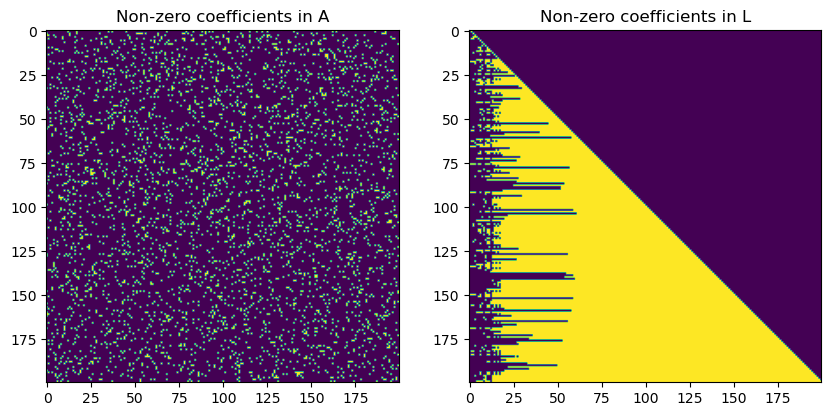

In [18]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

n = 200  
density = 0.1

random_sparse_matrix = sparse.random(n, n, density=density)

lu_decomposition = spla.splu(random_sparse_matrix)

L = lu_decomposition.L
U = lu_decomposition.U

print("Nombre de coefficients non-nuls dans A : ", random_sparse_matrix.count_nonzero())
print("Nombre de coefficients non-nuls dans L : ",L.count_nonzero())
print("Nombre de coefficients non-nuls dans U : ",U.count_nonzero())

A = random_sparse_matrix.toarray()
A_binary = np.where(A != 0, 1, 0)

L = L.toarray()
L_binary = np.where(L != 0, 1, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) 

ax1.imshow(A_binary)
ax1.set_title("Non-zero coefficients in A")

ax2.imshow(L_binary)
ax2.set_title("Non-zero coefficients in L")

### Méthodes par point fixe **

Une façon de procéder est de décomposer $\mathbf A$ en :
$$
\mathbf A
=
\mathbf M - \mathbf N
$$
avec $\mathbf M$, une matrice facilement inversible. En injectant cette decomposition dans le problème initial, on a :
$$
(\mathbf M - \mathbf N)\cdot \mathbf x = \mathbf b,
$$
soit de manière équivalente : 
$$
\mathbf x = 
\mathbf M^{-1} \cdot
(\mathbf N\cdot \mathbf x + \mathbf b).
$$
On observe alors un problème de **point fixe** pour lequel on construit la suite suivante convergeant vers $\mathbf x$ :
$$
\mathbf x_{k+1}
=
\mathbf M^{-1} \cdot
(\mathbf N\cdot \mathbf x_k + \mathbf b).
$$
En pratique, on ne calcule pas d'inverse et on résoudra le problème linéaire suivant qui est simple à traiter pour trouver $\mathbf x_{k+1}$ :
$$
\mathbf M \cdot 
\mathbf x_{k+1}
=
\mathbf b_k
$$
avec $\mathbf b_k = \mathbf N\cdot \mathbf x_k + \mathbf b$.

De nombreux choix sont possibles pour la matrice $\mathbf M$ parmi lesquels $\mathbf M =  diag(\mathbf A)$ (**méthode de Jacobi**) ou encore $\mathbf M = diag(\mathbf A) + tri^-(\mathbf A)$ (**méthode de Gauss-Seidel**) où $tri^-(\mathbf A)$ est le triangle inférieur de $\mathbf A$.  

Globalement à chaque itération, on retrouve une complexité d'environ $O(n^2)$. Pour un nombre d'itérations important, les performances de l'algorithme peuvent être moyennes. Néanmoins, les matrices $\mathbf M$ et $\mathbf N$ ont moins de coefficients non-nuls à stocker que $\mathbf A$ : leur stockage est donc aisé. En outre, l'inversion du système est très rapide compte-tenu de la nature de $\mathbf M$ et on n'a pas de produit matrice-matrice : les itérations sont donc rapides à effectuer.

In [20]:
import numpy.linalg as la 

A = np.array([[4., 3., 0.], [0., 1., 0.1], [0.7, 0., 1.]])
A = A + A.T
b = np.array([[1., 1., 9.]])

print("A : \n", A)
print("b : \n", b)

n = b.size

#M = np.diag(np.diag(A)) #Jacobi
M = np.tril(A) #Gauss-Seidel

N = M - A

eps = 1.0e8
tolerance = 1.0e-4

x_old = np.zeros_like(b).T 
iteration = 0

while (eps > tolerance) and (iteration < 100):
    bk = N.dot(x_old) + b.T
    x_new = la.solve(M, bk)
    eps = la.norm(x_new - x_old)
    x_old = x_new
    iteration += 1
    
print("Iterations needed : ", iteration)
print("A.dot(x_new) : \n", A.dot(x_new))
    


A : 
 [[8.  3.  0.7]
 [3.  2.  0.1]
 [0.7 0.1 2. ]]
b : 
 [[1. 1. 9.]]
Iterations needed :  19
A.dot(x_new) : 
 [[1.00015137]
 [1.0000009 ]
 [9.        ]]


### Méthodes de Krylov 

Les **méthodes de Krylov** englobent un certain nombre de méthodes itératives qui reposent sur les espaces de Krylov. L'idéé principale est de minimiser de façon itérative le résidu $\mathbf r = \mathbf b - \mathbf A\cdot\mathbf x$ dans un espace de Krylov. Leur succès vient du fait qu'elles se basent sur des produits matrice-vecteur et qu'elles nécessitent seulement des objets légers à stocker, contrairement aux méthodes directes précédentes. 

On appelle espace de Krylov d'ordre $k$ noté $K_k(\mathbf A, \mathbf r)$, l'espace engendré par $\mathbf r, \mathbf A\cdot \mathbf r, ..., \mathbf A^{k-1}\cdot \mathbf r$ :
$$
K_k(\mathbf A, \mathbf r) =
Vect
\left (
\mathbf r, \mathbf A\cdot \mathbf r, ..., \mathbf A^{k-1}\cdot \mathbf r
\right)
$$
On notera $\mathbf r_k$ le résidu à l'itération $k$ : 
$$
\mathbf r_k = \mathbf b - \mathbf A\cdot\mathbf x_k
$$
Par simplifier les notations, on considérera $\mathbf x_0 = \mathbf 0$.

#### Méthode du gradient conjugué ***

L'idée principale de la méthode du **gradient conjugué** est transformer le problème initial : 
$$
\mathbf A \cdot \mathbf x = 
\mathbf b
$$
en un problème de **minimisation** avec $\mathbf A$ est une matrice symétrique définie positive. La solution $\mathbf x^*$ du problème précédent et aussi celle qui minise la quantité scalaire suivante $J$:
$$
J(\mathbf x)
=
\frac{1}{2} 
\langle
 \mathbf A \mathbf x,
 \mathbf x
 \rangle
-
\langle
\mathbf b,
\mathbf x
\rangle,
$$
soit
$$
\mathbf x^* = 
\min_{\mathbf x}
J(\mathbf x).
$$
On  peut voir $J$ comme une primitive du problème du problème initial, formant un problème convexe associé.

On construit une suite de $\mathbf x_k$ telle que chaque $\mathbf x_k$ minise $J$ dans $K_k(\mathbf A, \mathbf r_0)$. Vu autrement, $\mathbf x_k$ est la projection de $\mathbf x^*$ dans $K_k(\mathbf A, \mathbf r_0)$.
On note qu'on retrouve la solution $\mathbf x^*$ pour $k=n_{dof}$ (i.e. $\mathbf x^* = \mathbf x_{n_{dof}}$) mais le grand intérêt de cette méthode réside dans le fait de donner une très bonne approximation de la solution au bout de peu d'itérations ($k\ll n_{dof}$).

Le passage de $\mathbf x_k$ à $\mathbf x_{k+1}$ se fait comme suit : 
$$
\mathbf x_{k+1} = 
\mathbf x_{k}
+
\alpha_k
\mathbf p_k
$$
où $\mathbf p_k$ est la direction de descente et $\alpha_k$ un scalaire. La direction de descente $\mathbf p_k$ appartient à $K_{k+1}(\mathbf A, \mathbf r_0)$ et conjuguée (d'où le nom de la méthode) à $K_{k}(\mathbf A, \mathbf r_0)$ par $\mathbf A$, ce qui veut dire que :
$$
\langle\mathbf A\cdot \mathbf p_k, \mathbf y\rangle = 0 \quad \forall \mathbf y \in K_{k}(\mathbf A, \mathbf r_0)
$$
ou, avec les mains, la direction de descente est perpendiculaire à $K_{k}(\mathbf A, \mathbf r_0)$ par application de $\mathbf A$. Cette direction de descente $\mathbf p_k$ s'exprime aussi par récurrence : 
$$
\mathbf p_{k+1} = 
\mathbf r_{k+1} + \beta_k \mathbf p_k.
$$
Les scalaires $\alpha_k$ et $\beta_k$ s'expriment : 
$$
\alpha_k = 
\frac{\|\mathbf r_k\|^2}{\langle \mathbf A \cdot \mathbf p_k, \mathbf p_k \rangle},
$$

$$
\beta_k = 
\frac{\|\mathbf r_{k+1} \|^2}{\|\mathbf r_{k} \|^2}.
$$
On constate qu'à chaque itération la complexité de la méthode se limite à celle du produit matrice-vecteur.

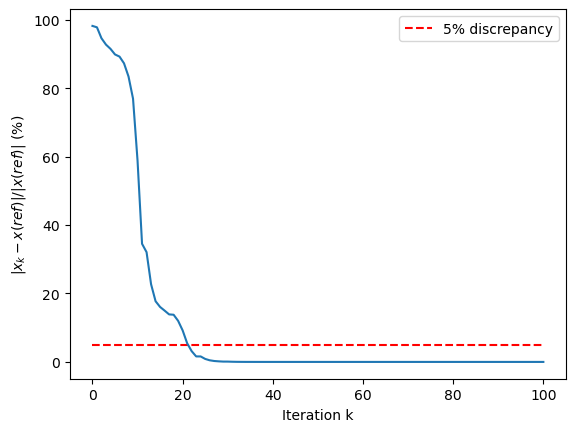

In [58]:
import numpy as np
import numpy.linalg as la

from sklearn.datasets import make_spd_matrix

problem_size = 100

A = make_spd_matrix(problem_size)
b = np.random.rand(problem_size)

x_sol = np.dot(la.inv(A), b)

x = np.zeros_like(b)
N = b.size
r = b - A.dot(x)
p = r

distance_list = list()

for i in range(N + 1):
    Ap = A.dot(p)
    alpha = la.norm(r)**2./Ap.dot(p)
    x += alpha*p
    r_new = r - alpha*Ap
    beta = la.norm(r_new)**2./la.norm(r)**2.
    p = r_new + beta*p
    r = r_new
    #print("x", i, "=", x)
    distance = 100.*la.norm(x - x_sol)/la.norm(x_sol)
    distance_list.append(distance)

distance_list = np.array(distance_list)

distance_5 = distance_list[np.where(distance_list > 5.)]

plt.hlines(5., xmin=0, xmax=problem_size, color="r", linestyle="dashed", label="5% discrepancy")
plt.plot(range(N + 1), distance_list)
plt.xlabel("Iteration k")
plt.ylabel("$\|x_k - x(ref)\|/\|x(ref)|$ (%)")
plt.legend()

#### GMRES ***

La méthode **GMRES**, pour Generalised Minimal Residual, est une méthode courante qui se base aussi sur les espaces de Krylov. Cette méthode relaxe des hypothèses du gradient conjugué : $\mathbf A$ doit être seulement inversible ici. L'idée est que chaque itéré $\mathbf x_k$ minimise la norme du résidu $\mathbf r_k$ sur $K_k(\mathbf A, \mathbf r_0)$ :
$$
\mathbf x_k = 
\arg \min_{\mathbf x \in K_r(\mathbf A, \mathbf r_0)} \|\mathbf r_k \|_2.
$$
Par définition, les vecteurs $\mathbf r_0, \mathbf A \cdot \mathbf r_0,..., \mathbf A^{k-1}\cdot \mathbf r_0$ constituent une base de $K_k(\mathbf A, \mathbf r_0)$. Cependant, lorsque $k$ augmente, ces vecteurs deviennent de moins en moins linéairement indépendants et consitutent donc une "mauvaise" base de $K_r(\mathbf A, \mathbf r_0)$.

Une stratégie consiste alors à construire une base orthonormée $(\mathbf v_1,...,\mathbf v_{k})$ de $K_k(\mathbf A, \mathbf r_0)$ à partir de la **méthode d'Arnoldi**, analogue à l'orthonormalisation de Gram-Schmidt pour les espaces de Krylov. On note $\mathbf V_k \in \mathbb R^{n_{dof}\times k}$ la matrice rectangulaire dont les colonnes correspondent aux $\mathbf v_k$. On peut alors passer de $\mathbf x_k \in \mathbb R^{n_{dof}}$ à $\mathbf y_k\in \mathbb R^{k}$ via cette matrice :
$$
\mathbf x_k 
=
\mathbf V_k \cdot \mathbf y_k.
$$
On fera aussi intervenir une matrice (d'Hessenberg) $\mathbf H_k\in \mathbb R^{k+1\times k}$ telle que :
$$
(\mathbf H_k)_{ij}
=
\langle
\mathbf A\cdot \mathbf v_i,
\mathbf v_j
\rangle
$$
et pour laquelle on a la relation suivante : 
$$
\mathbf A \cdot \mathbf V_k 
=
\mathbf V_{k+1} \cdot \mathbf H_k.
$$
Ces relations précédemment introduites permettent, en les injectant dans le problème initial $\| \mathbf b - \mathbf A\cdot \mathbf x \|_2$ d'aboutir au problème équivalent suivant : 
$$
\min_{\mathbf y_k}
\|\beta \mathbf e_1
- 
\mathbf H_k\cdot \mathbf  y_k
\|_2
$$
où $\beta = \|r_0\|$ et $\mathbf e_1 = (1,0,...,0)$, premier vecteur de la base canonique de $\mathbb R^{k+1}$. Ce problème correspond à un **problème des moindres carrés** dont la taille est passée de $n_{dof}$ à $k$. Une fois la solution obtenue, on la multipliera par $\mathbf V_k$ pour obtenir $\mathbf x_k$.

Text(0, 0.5, 'Error w.r.t. reference solution')

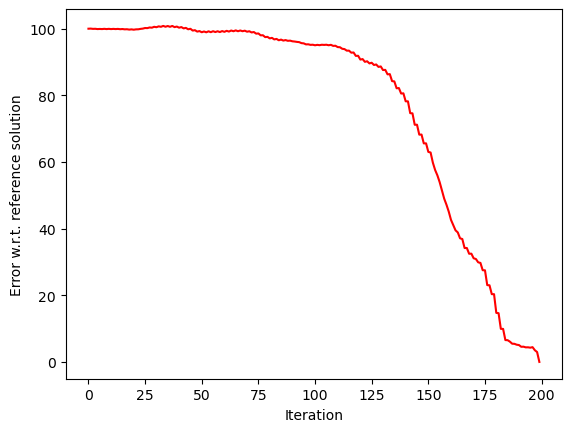

In [71]:
import numpy.linalg as la 
import scipy.optimize as sc_opt
import matplotlib.pyplot as plt

def func(x):

    return H[:(j+2), :(j+1)].dot(x) - beta*e1

n_dof = 200
k = 200
tol = 1.0e-5

A = np.random.rand(n_dof, n_dof)
A = A + A.T
b = np.random.rand(n_dof)
x_ref = la.solve(A, b)

x = np.zeros_like(b)
eps_list = []

Q = np.empty((b.size, k + 1))
H = np.zeros((k + 1, k))
r0 = b - A.dot(x)
beta = la.norm(r0)
Q[:, 0] = r0/beta

for j in range(k):
    Q[:, j + 1] = A.dot(Q[:, j])
    for i in range(j + 1):
        H[i, j] = Q[:, i].dot(Q[:, j + 1])
        Q[:, j + 1] = Q[:, j + 1] - H[i, j]*Q[:, i]
    H[j + 1, j] = la.norm(Q[:, j + 1])
    if H[j + 1, j] > tol :
        Q[:, j+1] = Q[:, j+1]/ H[j + 1, j]
        
    x_ls = np.zeros_like(H[:(j+1), 1])
    
    term = H[:(j+2), :(j+1)].dot(x_ls)
    e1 = np.zeros(term.shape)
    e1[0] = 1
    y = sc_opt.least_squares(func, x_ls).x
    res = la.norm(H[:(j+2), :(j+1)].dot(y) - beta*e1)
    
    x_res = Q[:, :(j+1)].dot(y)
    
    eps_list.append(100.*la.norm(x_ref - x_res)/la.norm(x_ref))

#print(b)
#print(A.dot(x_res))

plt.plot(eps_list, "r")
plt.xlabel("Iteration")
plt.ylabel("Error w.r.t. reference solution")
    

### Conditionnement **

Bien que les solveurs itératifs présentent de nombreux avantages, ils présentent un inconvénient de taille : leur convergence est liée au **conditionnement** du problème. Le conditionnement d'une matrice mesure en quelque sorte la difficulté de son inversion donc du problème numérique associé :
$$
Cond(\mathbf A) = 
\|\mathbf A\|
\cdot
\|\mathbf A^{-1}\|.
$$
On trouvera dans les problèmes éléments finis usuels des matrices très mal conditionnées :
$$
Cond(\mathbf A) \gg 1.
$$
On peut voir le conditionnement comme une mesure de la sensibilité de la matrice $\mathbf A$ à une perturbation. Partant du problème $\mathbf A \cdot \mathbf x = \mathbf b$, on suppose une petite variation sur $\mathbf A$ nommée $\delta \mathbf A$, induisant une petite variation sur $\mathbf x$ nommée $\delta \mathbf x$. On va chercher à mesurer l'amplitude de cette variation $\delta \mathbf x$.

Pour cela, on forme : 
$$
(\mathbf A + \delta \mathbf A) \cdot (\mathbf x + \delta \mathbf x) = \mathbf b.
$$
En développant et négligeant les termes d'ordre 2, on a :
$$
\delta \mathbf x = 
- 
\mathbf A^{-1}\cdot
\delta \mathbf A \cdot
\mathbf x.
$$
En passant à la norme et compte-tenu des propriétés de la norme : 
$$
\| \delta \mathbf x \|
\le
\|\mathbf A^{-1}\|
\cdot
\|\delta \mathbf A\| 
\cdot
\|
\mathbf x\|.
$$
On fait ensuite apparaître le conditionnement en utilisant sa définition. En réarrangeant, on aboutit à :
$$
\frac{\| \delta \mathbf x \|}{\|
\mathbf x\|}
\le
Cond(\mathbf A)
\frac{
\| \delta \mathbf A\|}
{\| \mathbf A\| }
.
$$
On voit alors que l'intensité de $\delta \mathbf x$ augmente directement avec le conditionnement. Concrètement, cela veut dire qu'une petite erreur sur la matrice de rigidité d'un problème, par exemple liée aux **arrondis numériques**, peut mener à une erreur importante sur la solution lorsque le conditionnement est mauvais. La maîtrise du conditionnement d'un problème est donc essentielle.

In [191]:
A = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

b = np.array([1, 1, 1])

cond = la.norm(A)*la.norm(la.inv(A))

delta = 1.0e-2

x = la.solve(A, b)
x_pert = la.solve(A + delta, b)

variation_on_x = 100.*la.norm(x_pert - x)/la.norm(x)

print("Condition number of A : ", cond)
print("Perturbation magnitude : ", delta)
print("Relative variation between x with A and perturbated A (%) : ", variation_on_x)

Condition number of A :  3.193239515623568e+17
Perturbation magnitude :  0.01
Relative variation between x with A and perturbated A (%) :  48.99643177238539


### Préconditionnement **

On peut chercher alors à résoudre un problème équivalent à $\mathbf A \cdot \mathbf x = \mathbf b$ mais mieux conditionné. On parle de méthode de **préconditionnement**. On cherchera alors une matrice $\mathbf P$, facilement inversible, telle que : 
$$
\mathbf P^{-1}\cdot\mathbf A \cdot \mathbf x = 
\mathbf P^{-1}\cdot\mathbf b
$$
donne un problème mieux conditionné que le problème initial. Ainsi le choix d'un bon préconditionneur permettra aux méthodes itératives abordées précédemment de converger beaucoup plus rapidement. Néanmoins, ce choix n'est pas aisé et dépend du problème considéré. On constate qu'en prenant $\mathbf P = \mathbf A$, obtient directement la solution $\mathbf x$. Néanmoins, la matrice $\mathbf A$ est difficilement inversible, ce qui en fait un mauvais candidat. On cherchera alors une matrice suffisamment proche de $\mathbf A$ mais simplement inversible. Typiquement, on peut choisir en pratique :
$$
\mathbf P = \mathbf D
$$
où $\mathbf D$ est la diagonale de $\mathbf A$. Il s'agit généralement d'un préconditionneur peu performant : il n'est jamais utilisé en pratique. Un choix commun est pae exemple de réaliser une factorisation de Cholesky incomplète qui consiste à approcher la factorisation de Cholesky de la manière suivante : 
$$
\mathbf A \approx
\tilde{\mathbf L}\cdot \tilde{\mathbf L}^T
=
\mathbf P
$$
avec $\tilde{\mathbf L}$, une matrice creuse.

In [197]:
A = np.array([[1, 2, 3],
              [2, 3, 6],
              [7, 8, 9]])

P = np.diag(np.diag(A))
P_inv = la.inv(P)
P_inv_A = P_inv.dot(A)

cond = la.norm(A)*la.norm(la.inv(A))
cond2 = la.norm(P_inv_A)*la.norm(la.inv(P_inv_A))

print(cond)
print(cond2)

47.57129152942748
23.994033609087477


## Conclusion

Nous avons vu que dans le cas linéaire, les problèmes se résumaient généralement à la résolution d'un problème classique d'algèbre linéaire de la forme $\mathbf A\cdot \mathbf x = \mathbf b$. Nous avons détaillé les stratégies usuelles pour la résolution de problèmes de ce type. Les méthodes directes permettent de donner une solution exacte du problème en réalisation l'inversion frontale du système d'équations. Cette tâche est généralement plus aisée pour des systèmes triangulaires. On se ramenera ainsi à ce type de problèmes à l'aide d'algorithmes de factorisation. Néanmoins, ces algorithmes deviennent rapidement coûteux lorsque le nombre de degré de liberté augmente, tant en terme d'occupation mémoire que de complexité temporelle. Cela nous mène à l'emploi de méthodes itératives, qui approchent la solution de façon itérative. Ces dernières permettent un coût de stockage amoindri dans la mesure où elles ne nécessitent pas de matrice auxiliaire lourde. De plus, ces méthodes emploient généralement des produits matrice-vecteur, plus légers et facilement parallélisable. Cependant, leur convergence n'est pas assurée dans le cas général mais dépend de différents facteurs comme le conditionnement du problème. Heureusement, celui-ci peut être amélioré grâce à des méthodes de préconditionnement.